# Geocoding 

### Source: [Automating GIS-processes 2021](https://autogis-site.readthedocs.io/en/latest/lessons/L3/overview.html)

### Data available [here](https://github.com/dahlalex/website/tree/main/notebooks)

### The goal is to geocode some addresses and make spatial join.

In [1]:
import pandas as pd
import geopandas as gpd
from geopandas.tools import geocode
import folium
import matplotlib.pyplot as plt
import requests
import geojson
from pyproj import CRS
%matplotlib inline

### 1- Geocode the addresses

In [2]:
# Read the data (These addresses are located in the Helsinki Region in Southern Finland.)

fb = r"data/addr_autogis.txt"
data = pd.read_csv(fb, sep=";")


In [3]:
data.shape

(34, 2)

In [4]:
data.head()

,id,addr
0,1000,"Itämerenkatu 14, 00101 Helsinki, Finland"
1,1001,"Kampinkuja 1, 00100 Helsinki, Finland"
2,1002,"Kaivokatu 8, 00101 Helsinki, Finland"
3,1003,"Hermannin rantatie 1, 00580 Helsinki, Finland"
4,1005,"Tyynenmerenkatu 9, 00220 Helsinki, Finland"


In [5]:
# Geocode addresses using Nominatim (Open Street Map), "custom application name" in the user_agent parameter, 
# timeout-parameter which specifies how many seconds we will wait for a response from the service.

addr = geocode(data["addr"], provider='nominatim', user_agent= "autogis_alex", timeout=4)

In [6]:
addr.head()

,geometry,address
0,POINT (24.91556 60.16320),"Ruoholahti, 14, Itämerenkatu, Ruoholahti, Läns..."
1,POINT (24.93166 60.16905),"Kamppi, 1, Kampinkuja, Kamppi, Helsinki, Helsi..."
2,POINT (24.94179 60.16989),"Kauppakeskus Citycenter, 8, Kaivokatu, Kluuvi,..."
3,POINT (24.97835 60.18976),"Hermannin rantatie, Verkkosaari, Kalasatama, S..."
4,POINT (24.92160 60.15665),"Hesburger, 9, Tyynenmerenkatu, Jätkäsaari, Län..."


In [7]:
addr = addr.join(data)

In [8]:
addr.head()

,geometry,address,id,addr
0,POINT (24.91556 60.16320),"Ruoholahti, 14, Itämerenkatu, Ruoholahti, Läns...",1000,"Itämerenkatu 14, 00101 Helsinki, Finland"
1,POINT (24.93166 60.16905),"Kamppi, 1, Kampinkuja, Kamppi, Helsinki, Helsi...",1001,"Kampinkuja 1, 00100 Helsinki, Finland"
2,POINT (24.94179 60.16989),"Kauppakeskus Citycenter, 8, Kaivokatu, Kluuvi,...",1002,"Kaivokatu 8, 00101 Helsinki, Finland"
3,POINT (24.97835 60.18976),"Hermannin rantatie, Verkkosaari, Kalasatama, S...",1003,"Hermannin rantatie 1, 00580 Helsinki, Finland"
4,POINT (24.92160 60.15665),"Hesburger, 9, Tyynenmerenkatu, Jätkäsaari, Län...",1005,"Tyynenmerenkatu 9, 00220 Helsinki, Finland"


In [22]:
out_fp= r"data/addr_helsinki.shp"
addr.to_file(out_fp)

C:\Users\dahla\miniconda3\envs\autogis2021\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


### 2- Get data (Population grid 250m x 250m) that contains population information from the Helsinki Region.

In [9]:
# Specify the url for web feature service
url = 'https://kartta.hsy.fi/geoserver/wfs'

# Specify parameters (read data in json format). 
# Available feature types in this particular data source: http://geo.stat.fi/geoserver/vaestoruutu/wfs?service=wfs&version=2.0.0&request=describeFeatureType
params = dict(service='WFS', 
              version='2.0.0', 
              request='GetFeature', 
              typeName='asuminen_ja_maankaytto:Vaestotietoruudukko_2018', 
              outputFormat='json')

# Fetch data from WFS using requests
r = requests.get(url, params=params)

# Create GeoDataFrame from geojson
pop = gpd.GeoDataFrame.from_features(geojson.loads(r.content))

In [10]:
pop.head()

,geometry,index,asukkaita,asvaljyys,ika0_9,ika10_19,ika20_29,ika30_39,ika40_49,ika50_59,ika60_69,ika70_79,ika_yli80
0,"POLYGON ((25472499.995 6689749.005, 25472499.9...",688,9,28.0,99,99,99,99,99,99,99,99,99
1,"POLYGON ((25472499.995 6685998.998, 25472499.9...",703,5,51.0,99,99,99,99,99,99,99,99,99
2,"POLYGON ((25472499.995 6684249.004, 25472499.9...",710,8,44.0,99,99,99,99,99,99,99,99,99
3,"POLYGON ((25472499.995 6683999.005, 25472499.9...",711,5,90.0,99,99,99,99,99,99,99,99,99
4,"POLYGON ((25472499.995 6682998.998, 25472499.9...",715,11,41.0,99,99,99,99,99,99,99,99,99


In [11]:
# Change the name of a column
pop = pop.rename(columns={"asukkaita":"pop18"})

# get rid of unnecessary columns
pop = pop[["pop18", "geometry"]]

In [12]:
pop.head()

,pop18,geometry
0,9,"POLYGON ((25472499.995 6689749.005, 25472499.9..."
1,5,"POLYGON ((25472499.995 6685998.998, 25472499.9..."
2,8,"POLYGON ((25472499.995 6684249.004, 25472499.9..."
3,5,"POLYGON ((25472499.995 6683999.005, 25472499.9..."
4,11,"POLYGON ((25472499.995 6682998.998, 25472499.9..."


### 3- join the data

In [13]:
# check the coordinate system

print(addr.crs)
print(pop.crs)

EPSG:4326
None


In [14]:
# define the coordinate reference system as ETRS GK-25 (EPSG:3879) because we know what it is based on the population grid metadata.
pop = pop.set_crs("EPSG:3879")

In [15]:
# Let’s re-project addresses to the projection of the population layer
addr.to_crs(pop.crs, inplace= True)

In [16]:
print(addr.crs)
print(pop.crs)

EPSG:3879
EPSG:3879


In [17]:
print(addr.shape)
print(pop.shape)

(34, 4)
(5832, 2)


In [18]:
# make a spatial join
join = gpd.sjoin(addr, pop, how= "inner", predicate="within")

In [19]:
join.shape

(31, 6)

In [20]:
join.head()

,geometry,address,id,addr,index_right,pop18
0,POINT (25495311.608 6672258.695),"Ruoholahti, 14, Itämerenkatu, Ruoholahti, Läns...",1000,"Itämerenkatu 14, 00101 Helsinki, Finland",3252,515
1,POINT (25496206.216 6672909.016),"Kamppi, 1, Kampinkuja, Kamppi, Helsinki, Helsi...",1001,"Kampinkuja 1, 00100 Helsinki, Finland",3364,182
30,POINT (25496230.571 6672892.612),"Alepa, 1, Urho Kekkosen katu, Kamppi, Helsinki...",1031,"Urho Kekkosen katu 1, 00100 Helsinki, Finland",3364,182
2,POINT (25496768.622 6673002.004),"Kauppakeskus Citycenter, 8, Kaivokatu, Kluuvi,...",1002,"Kaivokatu 8, 00101 Helsinki, Finland",3488,38
3,POINT (25498798.583 6675215.263),"Hermannin rantatie, Verkkosaari, Kalasatama, S...",1003,"Hermannin rantatie 1, 00580 Helsinki, Finland",3822,61


### 4- plot the data

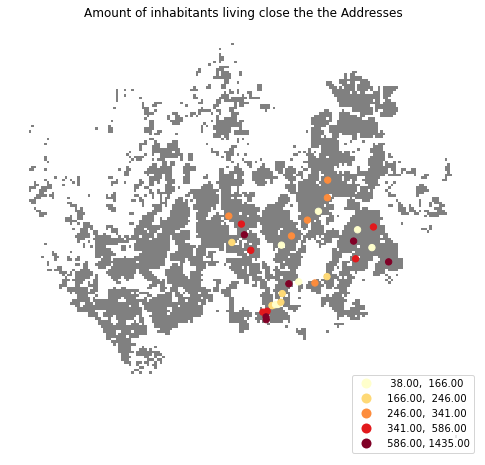

In [21]:
fig, ax = plt.subplots(figsize=(15, 8))

pop.plot(ax=ax, color="gray")
      
  
join.plot(ax= ax, column= "pop18", scheme= "quantiles", cmap="YlOrRd", markersize=40,
         legend= True, legend_kwds={'loc': 'lower right'})


plt.title("Amount of inhabitants living close the the Addresses")

ax.axis('off')

outfp = r"static_maps/addr_pop2018.png"
plt.savefig(outfp, facecolor="white")

plt.show()

